In [94]:
from dataloader import DAVIS_Seq2, normalize_image, BallDataset
from model import Model
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json

In [95]:
# data_set = BallDataset()
data_set = BallDataset("ellipse/uniform_samples_80.json")
# data_set = DAVIS_Seq2(is_one_video=True)

batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [96]:
pre_frame, curr_frame, pre_boundary, curr_boundary = next(iter(data_loader))

In [97]:
pre_frame.shape

torch.Size([1, 3, 224, 224])

Text(0.5, 1.0, 'Curr Frame')

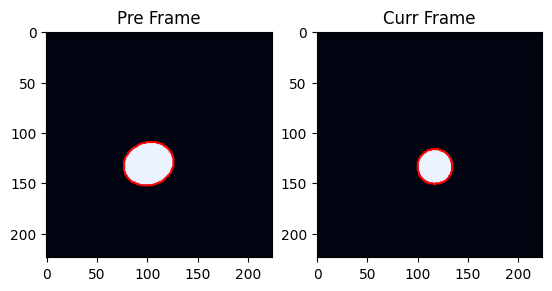

In [98]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 2, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')


In [99]:
model = Model()

In [100]:
def chamer_distance_loss(x, y):
    def bi_chamfer_distance(x, y):
        def chamfer_distance(a: torch.Tensor, b: torch.Tensor) -> float:
            total_min_dist = 0
            for i in range(a.shape[0]):
                total_min_dist += (b - a[i]).pow(2).sum(1).min(0)[0]
            return total_min_dist / a.shape[0]
        return chamfer_distance(x, y) + chamfer_distance(y, x)

    result = torch.tensor(0.0).to(x.device)
    for i in range(x.shape[0]):
        result += bi_chamfer_distance(x[i], y[i])

    return result / x.shape[0]

predict_boundary = pre_boundary.clone()
predict_boundary[:, :, 0] += 9
predict_boundary[:, :, 1] += -5
# print(curr_boundary - pre_boundary)
chamer_distance_loss(
    curr_boundary.float(),
    (predict_boundary).float()
)

tensor(166.0500)

In [101]:
pre_boundary.shape, curr_boundary.shape

(torch.Size([1, 80, 2]), torch.Size([1, 80, 2]))

In [102]:
def order_loss(x: torch.Tensor, y: torch.Tensor):
    def my_order_loss(x, y):
        min_loss = (x - y).abs().sum()
        for shift in range(1, x.shape[0]):
            # loss = (x - torch.roll(y, shifts=shift, dims=0)).pow(2).sum().sqrt()
            loss = (x - torch.roll(y, shifts=shift, dims=0)).abs().sum()
            min_loss = torch.min(min_loss, loss)
        return min_loss / x.shape[0]
        # return min_loss
        
    result = torch.tensor(0.0).to(x.device)
    for i in range(x.shape[0]):
        result += my_order_loss(x[i], y[i])

    return result / x.shape[0]
predict_boundary = pre_boundary.clone()
predict_boundary[:, :, 0] += 8
predict_boundary[:, :, 1] += -5
order_loss(curr_boundary, predict_boundary)

tensor(15.4750)

In [103]:
torch.cuda.empty_cache()

In [104]:
model = model.cuda()
output = model(pre_frame.to("cuda"), curr_frame.to("cuda"), pre_boundary.to("cuda")).cpu()
predic_boundary = output + pre_boundary
chamer_distance_loss(predic_boundary, curr_boundary.float())

tensor(271.6896, grad_fn=<DivBackward0>)

In [177]:
model = Model().to('cuda')
model_name = "uniform_model"
# data_set = BallDataset()
data_set = BallDataset("ellipse/uniform_samples_80.json")
# data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)
# loss_name = "chamer_distance_loss"
loss_name = "order_loss"
if loss_name == "chamer_distance_loss":
    loss_func = chamer_distance_loss
else:
    loss_func = order_loss
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [178]:
torch.cuda.memory_allocated() / 1024 / 1024 / 1024

2.7321033477783203

In [179]:
dict_loss = {}
num_epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
gradient_clip = 2
min_loss = 1e10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
for e in range(num_epochs):
    model.train()
    mean_loss = 0
    for pre_frame, curr_frame, pre_boundary, curr_boundary in tqdm(data_loader):
        pre_frame, curr_frame, pre_boundary, curr_boundary = (
            pre_frame.to("cuda"),
            curr_frame.to("cuda"),
            pre_boundary.to("cuda"),
            curr_boundary.to("cuda"),
        )
        optimizer.zero_grad()
        output = model(pre_frame, curr_frame, pre_boundary)
        predic_boundary = output + pre_boundary
        loss = loss_func(predic_boundary, curr_boundary.float())
        nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        loss.backward()
        optimizer.step()
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(model.state_dict(), f"./models/{model_name}_{loss_name}.pth")
        mean_loss += loss.item()
    mean_loss /= len(data_loader)
    dict_loss[e] = mean_loss
    scheduler.step()
    print(f"Epoch {e + 1}, Loss: {mean_loss}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.61it/s]


Epoch 1, Loss: 15.8655232379311


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.89it/s]


Epoch 2, Loss: 15.37159666262175


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.12it/s]


Epoch 3, Loss: 15.356262683868408


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.09it/s]


Epoch 4, Loss: 15.273574954585024


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.11it/s]


Epoch 5, Loss: 15.290201839647795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.91it/s]


Epoch 6, Loss: 15.230549235092965


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.03it/s]


Epoch 7, Loss: 15.21733045578003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.12it/s]


Epoch 8, Loss: 15.130567625949258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.96it/s]


Epoch 9, Loss: 15.4330987428364


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.00it/s]


Epoch 10, Loss: 15.325167078720895


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.20it/s]


Epoch 11, Loss: 15.150501928831401


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.90it/s]


Epoch 12, Loss: 15.110557982796117


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.80it/s]


Epoch 13, Loss: 15.055477945428146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.83it/s]


Epoch 14, Loss: 15.142272146124588


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.77it/s]


Epoch 15, Loss: 14.854252664666427


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.90it/s]


Epoch 16, Loss: 14.575240637126722


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.91it/s]


Epoch 17, Loss: 14.814883608567087


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:08<00:00,  2.24it/s]


Epoch 18, Loss: 14.564084554973402


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.51it/s]


Epoch 19, Loss: 14.635610781217876


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.86it/s]


Epoch 20, Loss: 14.352539639723929


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.17it/s]


Epoch 21, Loss: 14.416904926300049


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.77it/s]


Epoch 22, Loss: 13.976938423357511


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.76it/s]


Epoch 23, Loss: 13.963510287435431


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.32it/s]


Epoch 24, Loss: 13.953825323205246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.76it/s]


Epoch 25, Loss: 13.858336900409899


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.79it/s]


Epoch 26, Loss: 13.842542171478271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.85it/s]


Epoch 27, Loss: 13.865124213068109


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.18it/s]


Epoch 28, Loss: 13.837633195676302


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.43it/s]


Epoch 29, Loss: 13.760569672835501


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.09it/s]


Epoch 30, Loss: 13.71635012877615


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.89it/s]


Epoch 31, Loss: 13.950964463384528


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.90it/s]


Epoch 32, Loss: 13.620541321603875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.89it/s]


Epoch 33, Loss: 14.160066253260561


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.05it/s]


Epoch 34, Loss: 13.374433203747397


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.32it/s]


Epoch 35, Loss: 14.379160529688784


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.76it/s]


Epoch 36, Loss: 13.676051579023662


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.76it/s]


Epoch 37, Loss: 13.855858526731792


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.30it/s]


Epoch 38, Loss: 13.785264680260106


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.01it/s]


Epoch 39, Loss: 13.634739925986842


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.83it/s]


Epoch 40, Loss: 13.379064359162983


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.68it/s]


Epoch 41, Loss: 13.226487699307894


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.88it/s]


Epoch 42, Loss: 13.42601930467706


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.16it/s]


Epoch 43, Loss: 13.314733204088713


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.16it/s]


Epoch 44, Loss: 13.9300066295423


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.16it/s]


Epoch 45, Loss: 13.77202336411727


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.58it/s]


Epoch 46, Loss: 13.805635427173815


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.29it/s]


Epoch 47, Loss: 13.279972189351133


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.29it/s]


Epoch 48, Loss: 13.532997231734427


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.03it/s]


Epoch 49, Loss: 13.525491827412656


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.69it/s]


Epoch 50, Loss: 13.630517281984028


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.45it/s]


Epoch 51, Loss: 13.649038490496183


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.47it/s]


Epoch 52, Loss: 13.917464231189928


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.84it/s]


Epoch 53, Loss: 13.552675711481195


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.92it/s]


Epoch 54, Loss: 13.46793112001921


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.64it/s]


Epoch 55, Loss: 13.35989519169456


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.81it/s]


Epoch 56, Loss: 13.290923959330508


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.84it/s]


Epoch 57, Loss: 13.361697284798874


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.81it/s]


Epoch 58, Loss: 13.595441805688958


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.11it/s]


Epoch 59, Loss: 13.788285933042827


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.86it/s]


Epoch 60, Loss: 13.48973580410606


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.20it/s]


Epoch 61, Loss: 13.374610461686787


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.02it/s]


Epoch 62, Loss: 13.869069777036968


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.02it/s]


Epoch 63, Loss: 13.661163957495438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.96it/s]


Epoch 64, Loss: 13.690199927279824


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.26it/s]


Epoch 65, Loss: 13.625176868940654


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.55it/s]


Epoch 66, Loss: 13.576726185648065


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.18it/s]


Epoch 67, Loss: 13.909417691983675


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.94it/s]


Epoch 68, Loss: 13.758576518610903


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.95it/s]


Epoch 69, Loss: 13.531903103778237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.91it/s]


Epoch 70, Loss: 13.496427799526014


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.27it/s]


Epoch 71, Loss: 13.491556807568198


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.19it/s]


Epoch 72, Loss: 13.740701876188579


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.69it/s]


Epoch 73, Loss: 13.340209848002383


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.28it/s]


Epoch 74, Loss: 13.392506084944072


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.53it/s]


Epoch 75, Loss: 13.29879587575009


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.16it/s]


Epoch 76, Loss: 13.911032726890163


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.14it/s]


Epoch 77, Loss: 13.300535076542905


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.02it/s]


Epoch 78, Loss: 13.30637354599802


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.12it/s]


Epoch 79, Loss: 13.80588926767048


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.04it/s]


Epoch 80, Loss: 13.711479099173294


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.27it/s]


Epoch 81, Loss: 13.378523625825581


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.90it/s]


Epoch 82, Loss: 13.985416613127056


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.09it/s]


Epoch 83, Loss: 13.898535653164512


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.94it/s]


Epoch 84, Loss: 13.652887670617355


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.06it/s]


Epoch 85, Loss: 13.45802166587428


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.97it/s]


Epoch 86, Loss: 13.317024180763646


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.96it/s]


Epoch 87, Loss: 13.649389505386353


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.20it/s]


Epoch 88, Loss: 13.65508676830091


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.90it/s]


Epoch 89, Loss: 13.706634621871146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.16it/s]


Epoch 90, Loss: 13.472617425416646


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.11it/s]


Epoch 91, Loss: 13.507779711171201


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.68it/s]


Epoch 92, Loss: 13.44245753790203


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.78it/s]


Epoch 93, Loss: 13.317236436040778


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.99it/s]


Epoch 94, Loss: 13.30406211551867


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.71it/s]


Epoch 95, Loss: 13.280447721481323


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.10it/s]


Epoch 96, Loss: 13.757570141240171


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.90it/s]


Epoch 97, Loss: 13.26549556380824


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.83it/s]


Epoch 98, Loss: 13.450888345116063


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.05it/s]


Epoch 99, Loss: 13.28665522525185


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.05it/s]

Epoch 100, Loss: 13.633588753248516


In [180]:
# save loss
with open(f"./log/{model_name}_{loss_name}.json", "w") as f:
    json.dump(dict_loss, f)

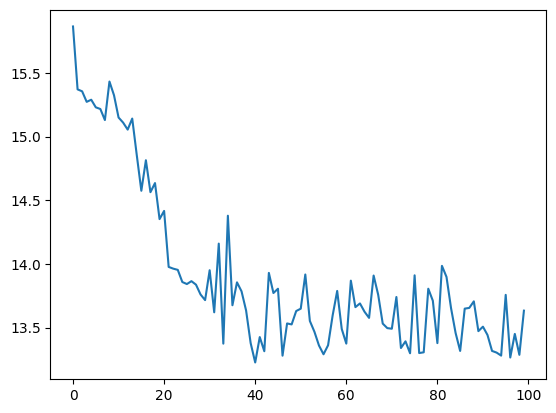

In [181]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()))

In [53]:
model = Model()
model_name = "uniform_model"
# model_name = "simplify_model"
loss_name = "order_loss"
# loss_name = "chamer_distance_loss"
model.load_state_dict(torch.load(f"./models/{model_name}_{loss_name}.pth"))
model = model.to("cuda")

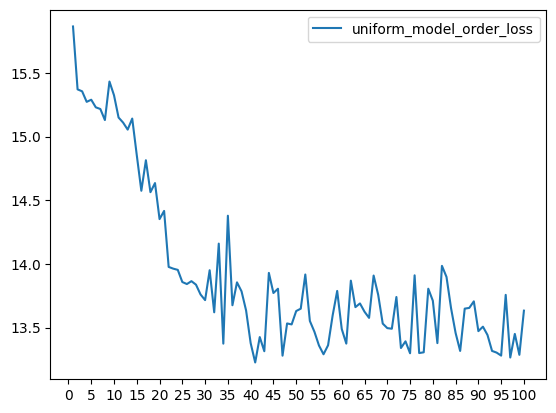

In [182]:
# load the loss
with open(f"./log/{model_name}_{loss_name}.json", "r") as f:
    dict_loss = json.load(f)
# plot the loss
plt.plot(np.array(list(dict_loss.keys())).astype(int) + 1, list(dict_loss.values()), label=f"{model_name}_{loss_name}")
# plt.legend(loc="lower right")
plt.legend()
# set the xticks
plt.xticks(np.arange(0, 101, 5))
plt.show()

In [43]:
class DAVIS_test(torch.utils.data.Dataset):
    def __init__(self, video_name: str, is_uniform=True):
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        if is_uniform:
            with open("./uniform_samples_80.json", "r") as f:
                tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        else:
            with open("./simplify_samples_80.json", "r") as f:
                tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        
        self.data = tmp_data[video_name]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, sgm_path, boundary = self.data[idx]
        img = Image.open(img_path)
        sgm = get_gray_image(sgm_path)
        img = self.transform(img)
        boundary = np.array(boundary).astype(np.int32)
        boundary = torch.tensor(boundary).int()
        return img, sgm, boundary

In [183]:
class Balltest(torch.utils.data.Dataset):
    def __init__(self, json_path="./ball/uniform_samples_80.json"):
        self.json_path = json_path
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        self.data = json.load(open(json_path, "r"))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, boundary = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        sgm = get_gray_image(img_path)
        boundary = np.array(boundary).astype(np.int32)
        boundary = torch.tensor(boundary).int()
        return img, sgm, boundary

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 25.20it/s]


0.03427500849305466

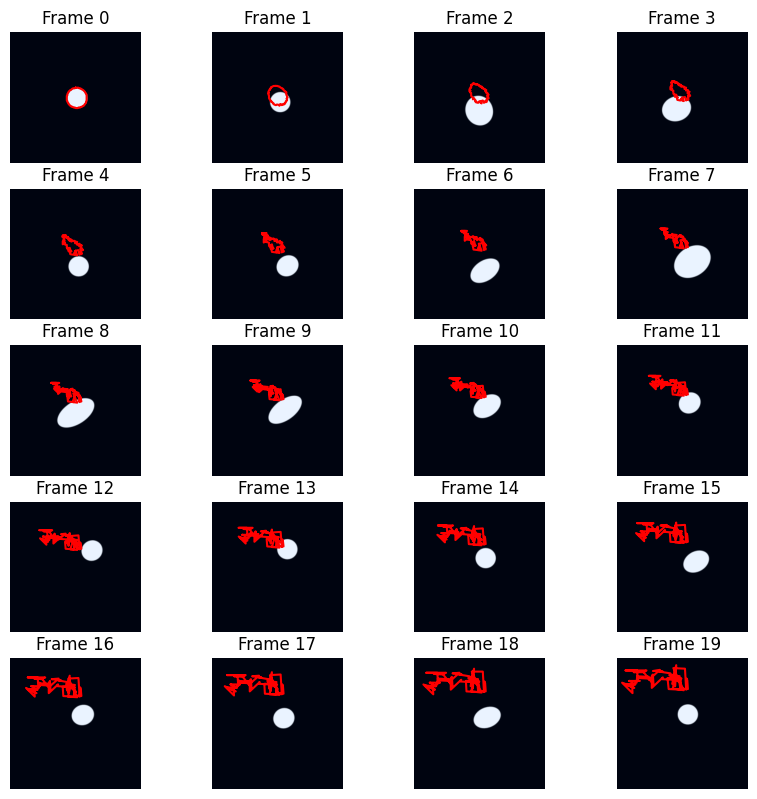

In [186]:
def test_model_one_video(model, test_dataset: torch.utils.data.Dataset, device="cuda"):
    pre_img, pre_sgm, pre_boundary = test_dataset[0]
    plt.figure(figsize=(10, 20))
    plt.subplot(10, 4, 1)
    plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
    plt.plot(pre_boundary[:, 0], pre_boundary[:, 1], 'r')
    plt.axis('off')
    plt.title('Frame 0')
    pre_boundary = pre_boundary.to(device)
    total_iou = 0
    model.eval()
    interval = 1
    for i in tqdm(range(1, len(test_dataset))):
        img, sgm, boundary = test_dataset[i]
        # print(pre_img.shape, img.shape, pre_boundary.shape)
        with torch.no_grad():
            boundary_offset = model(
                pre_img.unsqueeze(0).to(device),
                img.unsqueeze(0).to(device),
                pre_boundary.unsqueeze(0).to(device),
            )
            # pre_boundary[:, 0] += 9
            # print(boundary_offset)
            pre_boundary = pre_boundary + boundary_offset.squeeze(0)
            pre_boundary = pre_boundary.int()
            pre_boundary = torch.clamp(pre_boundary, 0, 223)
            # print(pre_boundary.cpu() - boundary)
            # pre_boundary = boundary.squeeze(0).to(device)
            pre_img = img
            if i % interval == 0:
                plt.subplot(10, 4, i // interval + 1)
                # plt.subplot(4, 4, i // interval)
                plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
                # index = 10
                # plt.scatter(pre_boundary.cpu().numpy()[:, 0][index], pre_boundary.cpu().numpy()[:, 1][index], )
                plt.plot(pre_boundary.cpu().numpy()[:, 0], pre_boundary.cpu().numpy()[:, 1], "r")
                plt.axis('off')
                plt.title(f'Frame {i}')
        total_iou += get_boundary_iou(sgm, pre_boundary.cpu().numpy())
    return total_iou / (len(test_dataset) - 1)
# if model_name == "uniform_model":
#     test_dataset = DAVIS_test("bear", is_uniform=True)
# else:
#     test_dataset = DAVIS_test("bear", is_uniform=False)
# test_dataset = Balltest()
test_dataset = Balltest("ellipse/uniform_samples_80.json")
test_model_one_video(model, test_dataset)